# Temporal Response Functions

In [14]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

import seaborn as sns
from mtrf.model import TRF
from mtrf.stats import crossval, pearsonr, neg_mse

import pymatreader
import random

## Example Regression

In [43]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
# Import necessary modules

# Generate some random data
np.random.seed(42)
X = np.random.rand(100, 50)
y = np.random.rand(100)

X_collinear = np.random.rand(100, 50)

# Create the remaining 5 columns as linear combinations of the existing columns
for i in range(25):
    new_col = X[:, i] * 2 + np.random.rand(100) * 0.01
    X_collinear = np.column_stack((X_collinear, new_col))

/var/folders/hq/25wkh5ks4x3bl8rfsmsnt_vw2w8qk_/T/ipykernel_44557/2321605436.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(np.arange(1, len(ridge.coef_)+1), ridge.coef_, '--bo', color = 'red')
/var/folders/hq/25wkh5ks4x3bl8rfsmsnt_vw2w8qk_/T/ipykernel_44557/2321605436.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  ax2.plot(np.arange(1, len(ridge_collinear.coef_)+1), ridge_collinear.coef_, '--bo', color = 'red')


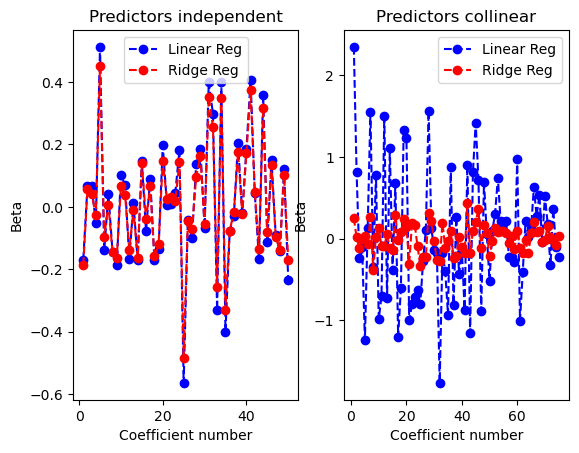

In [62]:
# Split the data into training (80) and testing sets (20)
X_train, X_test = X[:80], X[80:]
X_collinear_train, X_collinear_test = X_collinear[:80], X_collinear[80:]
y_train, y_test = y[:80], y[80:]

# Fit a linear regression model
lr = LinearRegression()
lr_collinear = LinearRegression()
lr.fit(X_train, y_train)
lr_collinear.fit(X_collinear_train, y_train)

# Fit a ridge regression model
ridge = Ridge(alpha=0.1)
ridge_collinear = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
ridge_collinear.fit(X_collinear_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(1, len(lr.coef_)+1), lr.coef_, '--bo')
ax1.plot(np.arange(1, len(ridge.coef_)+1), ridge.coef_, '--bo', color = 'red')
ax1.set_title("Predictors independent")
ax1.set_xlabel("Coefficient number")
ax1.set_ylabel("Beta")
ax1.legend(["Linear Reg", "Ridge Reg"])

ax2.plot(np.arange(1, len(lr_collinear.coef_)+1), lr_collinear.coef_, '--bo')
ax2.plot(np.arange(1, len(ridge_collinear.coef_)+1), ridge_collinear.coef_, '--bo', color = 'red')
ax2.set_title("Predictors collinear")
ax2.set_xlabel("Coefficient number")
ax2.set_ylabel("Beta")
ax2.legend(["Linear Reg", "Ridge Reg"])


In [68]:
# Compare the mean squared error of the two models on the test set
print("Predictors independent:")
print("Linear Regression MSE:", mean_squared_error(y_test, lr.predict(X_test)))
print("Ridge Regression MSE:", mean_squared_error(y_test, ridge.predict(X_test)))

print("Predictors collinear:")
print("Linear Regression MSE:", mean_squared_error(y_test, lr_collinear.predict(X_collinear_test)))
print("Ridge Regression MSE:", mean_squared_error(y_test, ridge_collinear.predict(X_collinear_test)))

Predictors independent:
Linear Regression MSE: 0.4038396338415672
Ridge Regression MSE: 0.33116653323991196
Predictors collinear:
Linear Regression MSE: 4.496803182826639
Ridge Regression MSE: 0.2427591647894491


## Example Dataset

In [2]:
datapath = "/Users/b1019548/Library/CloudStorage/OneDrive-UniversitätSalzburg/Teaching/Master_VO_MethodsCogNeuro//Lecture6_TRFs/data/19950913GBWL.mat"

info = mne.io.read_info("sample-info.fif", verbose = True)
info = mne.Info(info, sfreq=100)

data = pymatreader.read_mat(datapath)
#find out what is inside:
#data['corona_preprocData'].keys()

fs = data['corona_preprocData']['fsample'] #sampling rate ... strongly downsampled to 50 Hz
megdata = data['corona_preprocData']['trial'] #40 trials overall

Durations are not equal. Let's check.

Text(0.5, 0, 'Trial Number')

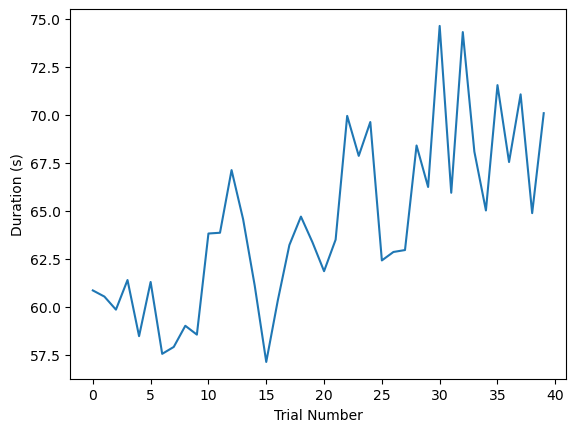

In [3]:
num_cols = []
for trial in megdata:
    num_cols.append(trial.shape[1])
    
plt.plot(range(0, len(num_cols)), np.divide(num_cols, fs))
plt.ylabel("Duration (s)")
plt.xlabel("Trial Number")


For mTRF let's create a response and stimulus list. We need to transponse as the mtrf functions wants data as samples x channels / features 

In [44]:
# get the neural data
response = []
stimulus = []

indices = np.where(data['corona_preprocData']['trialinfo'][:,1] == 0)
indices_sel = random.sample(range(0, len(indices[0])), 25)

# we will only pick trials without distractor and pick 5 trials (i.e. ~5 mins data)
for ii in indices_sel:
    trial = megdata[indices[0][ii]]
    trial = zscore(trial, axis=1)
    response.append(trial[:306, :].transpose())
    stimulus.append(trial[[307], :].transpose())

find optimal regularization

Cross-validating[##################################################] 25/25....] 0/25

Cross-validating[##################################################] 25/25....] 1/25

Cross-validating[##################################################] 25/25....] 2/25

Cross-validating[##################################################] 25/25....] 3/25

Cross-validating[##################################################] 25/25....] 4/25

Cross-validating[##################################################] 25/25....] 5/25

Cross-validating[##################################################] 25/25....] 6/25

Cross-validating[##################################################] 25/25....] 7/25

Cross-validating[##################################################] 25/25....] 8/25

Cross-validating[##################################################] 25/25....] 9/25

Cross-validating[##################################################] 25/25....] 10/25

Cross-validating[####################################

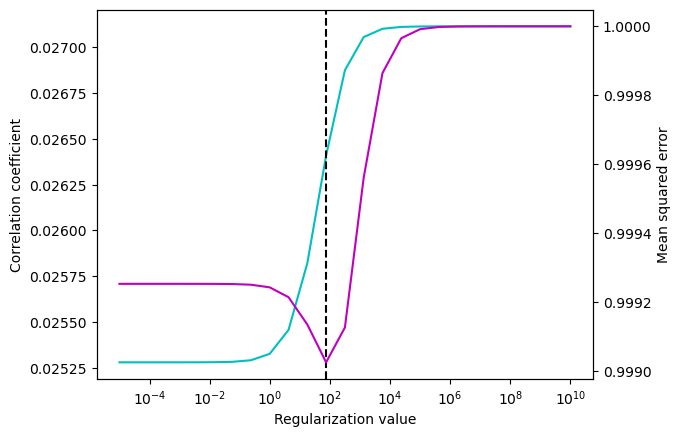

In [49]:
tmin, tmax = -.2, 0.6  # range of time lags
regularization = np.logspace(-5, 10, 25)

trf = TRF(direction=1, metric=neg_mse)  # use negative meas squared error
# multiply by -1 to get the mean squared error
mse = trf.train(stimulus, response, fs, tmin, tmax, regularization) * -1

trf = TRF(direction=1, metric=pearsonr)  # use pearsons correlation
r = trf.train(stimulus, response, fs, tmin, tmax, regularization)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.semilogx(regularization, r, color='c')
ax2.semilogx(regularization, mse, color='m')
ax1.set(xlabel='Regularization value', ylabel='Correlation coefficient')
ax2.set(ylabel='Mean squared error')
ax1.axvline(regularization[np.argmin(mse)], linestyle='--', color='k')
plt.show()

In [50]:
fwd_trf = TRF(direction=1)
tmin, tmax = -0.2, 0.6  # range of time lag
regval = regularization[np.argmin(mse)] # regularization parameter lambda
fwd_trf.train(stimulus, response, fs, tmin, tmax, regval)

Do leave-one-out crossvalidation

In [51]:
r_fwd = crossval(fwd_trf, stimulus, response, fs, tmin, tmax, regval)
print(f"mean correlation between actual and predicted response: {r_fwd.mean().round(3)}")

Cross-validating[##################################################] 25/25

mean correlation between actual and predicted response: 0.026


No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


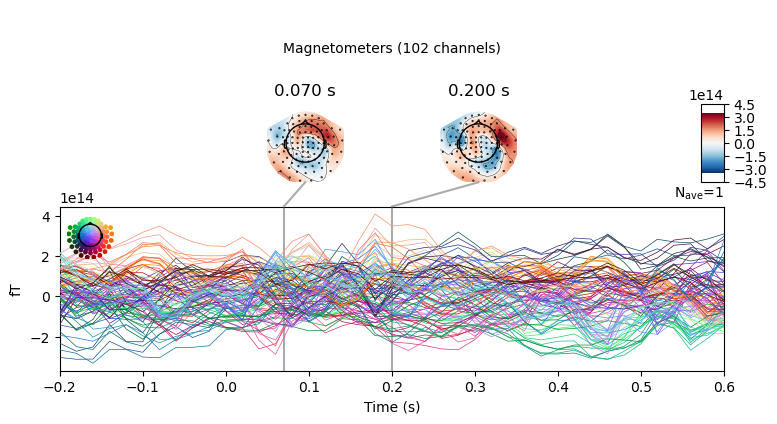

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


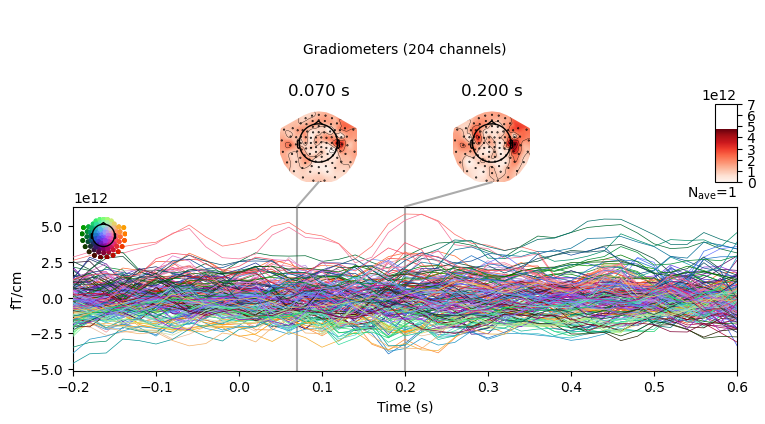

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [75]:
info = mne.io.read_info("sample-info.fif", verbose = True)
info = mne.Info(info, sfreq=fs)

meg_indices = mne.pick_types(info, meg=True)
reduced_info = mne.pick_info(info, meg_indices)

evokeds = fwd_trf.to_mne_evoked(info = reduced_info)
evokeds[0].plot_joint([0.07, 0.2, 0.45])

In [199]:
bwd_trf = TRF(direction=-1)
r_bwd = bwd_trf.train(stimulus, response, fs, tmin, tmax, regularization)
r_bwd = crossval(bwd_trf, stimulus, response, fs, tmin, tmax, regularization)
print(f"correlation between actual and predicted stimulus: {r_bwd.round(3)}")

In [125]:
?fwd_trf.predict

Signature: fwd_trf.predict(stimulus=None, response=None, lag=None, average=True)
Docstring:
Predict response from stimulus (or vice versa) using the trained model.

The matrix of TRF weights is multiplied with the time-lagged input to predict
the output. If the actual output is provided, this method will estimate the
correlation and mean squared error of the predicted and actual output.

Parameters
----------
stimulus: None or list or numpy.ndarray
    Either a 2-D samples-by-features array, if the data contains only one trial
    or a list of such arrays of it contains multiple trials. The second
    dimension can be omitted if there only is a single stimulus feature
    (e.g. envelope). When using a forward model, this must be specified.
response: None or list or numpy.ndarray
    Either a 2-D samples-by-channels array, if the data contains only one
    trial or a list of such arrays of it contains multiple trials. Must be
    provided when using a backward model.
lag: None or in or 

In [83]:
num_cols

[3043,
 3027,
 2993,
 3070,
 2924,
 3065,
 2878,
 2896,
 2951,
 2928,
 3191,
 3193,
 3356,
 3228,
 3056,
 2857,
 3017,
 3161,
 3235,
 3168,
 3093,
 3175,
 3497,
 3393,
 3481,
 3121,
 3143,
 3148,
 3420,
 3312,
 3731,
 3297,
 3715,
 3404,
 3251,
 3577,
 3377,
 3553,
 3244,
 3504]